In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training

In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import os
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using CUDA

In [18]:
def plot_conf_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
# pkl_path = '/content/drive/MyDrive/lipreader_data/val.pkl'
# with open(pkl_path, 'rb') as file:
#     data = pickle.load(file)
# label, _, coordinates = data[0]
# flat_coordinates = [coord for pair in coordinates for coord in pair]
# reshaped_coordinates = np.array(flat_coordinates).reshape(29, 80)

In [6]:
def read_data(pkl_path, label_encoder=None):
    features_list = []
    labels_list = []

    with open(pkl_path, 'rb') as file:
        raw_data = pickle.load(file)

    for label, _, coordinates in raw_data:
        flat_coordinates = [coord for pair in coordinates for coord in pair]
        reshaped_coordinates = np.array(flat_coordinates).reshape(29, 80)
        feature_tensor = torch.tensor(reshaped_coordinates, dtype=torch.float32)
        features_list.append(feature_tensor)
        labels_list.append(label)

    # Initialize label encoder if not provided
    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels_list)
    else:
        labels_encoded = label_encoder.transform(labels_list)
    labels_encoded = torch.tensor(labels_encoded, dtype=torch.long)

    return features_list, labels_encoded, label_encoder

In [7]:
def collate_fn(batch):
    features = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    features_tensor = torch.stack(features)
    # Ensure labels are at least 1D before concatenation
    labels_tensor = torch.cat([label.unsqueeze(0) for label in labels])

    return features_tensor, labels_tensor

In [8]:
# Custom Dataset class
class LipPointsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [9]:
class LipReadingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(LipReadingLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # Method 1: using output, fixed sequence length
        out = self.fc(output[:, -1, :])

        # Method 2: using h_n + c_n
        # combined = torch.cat((h_n.squeeze(0), c_n.squeeze(0)), dim=1)
        # out = self.fc(combined)

        # Method 3: using h_n, varied length
        # out = self.fc(h_n[-1])  ## the last hidden state of the last layer

        # Method 4: using output, varid length
        # packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)   # A list or tensor representing the actual lengths of the sequences before they were padded
        # packed_output, (h_n, c_n) = self.lstm(packed_input)
        # output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # out = self.fc(output[:, -1, :])  # Use the last hidden state
        return out

In [10]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch_features, batch_labels in dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predicted_labels = []
    all_true_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            # Calculate accuracy
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

            # Collect all labels and predictions for confusion matrix
            all_predicted_labels.extend(predicted_labels.tolist())
            all_true_labels.extend(batch_labels.tolist())

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    return average_loss, accuracy, conf_matrix

In [12]:
def plot_metrics(train_losses, val_losses, train_accuracies=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if train_accuracies and val_accuracies:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'b-', label='Training accuracy')
        plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

In [14]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0

        if self.verbose and self.early_stop:
            pass
            # print(f"Early stopping triggered after {self.patience} epochs without improvement")

In [24]:
def main(params):
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Paths and data setup
    pkl_path = '/content/drive/MyDrive/lipreader_data'
    train_pkl_path = os.path.join(pkl_path, 'train.pkl')
    val_pkl_path = os.path.join(pkl_path, 'val.pkl')
    test_pkl_path = os.path.join(pkl_path, 'test.pkl')

    # Initialize label encoder and ensure it is only fitted once
    _, _, label_encoder = read_data(train_pkl_path)
    train_features_list, train_labels_encoded, _ = read_data(train_pkl_path, label_encoder)
    val_features_list, val_labels_encoded, _ = read_data(val_pkl_path, label_encoder)
    test_features_list, test_labels_encoded, _ = read_data(test_pkl_path, label_encoder)
    print ('Finished reading data!')

    train_dataset = LipPointsDataset(train_features_list, train_labels_encoded)
    val_dataset = LipPointsDataset(val_features_list, val_labels_encoded)
    test_dataset = LipPointsDataset(test_features_list, test_labels_encoded)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
    print ('Finished loading data!')

    # Model setup
    input_size = 80  # Number of features per time step
    hidden_size = params['hidden_size']
    num_classes = len(label_encoder.classes_)
    num_layers = params['num_layers']

    model = LipReadingLSTM(input_size, hidden_size, num_classes, num_layers)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    early_stopping = EarlyStopping(patience=20, verbose=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    # Training and validation loop
    for epoch in range(params['epoch']):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _ = evaluate(model, val_loader, criterion, device)

        # Collect metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}')

        # Call early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            # print("Early stopping")
            break

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    # Evaluate on test set after fine-tuning
    test_loss, test_accuracy, conf_matrix = evaluate(model, test_loader, criterion, device)

    print(f'Total Training epoch: {epoch}, Test Accuracy: {test_accuracy:.4f}')
    # print(f'Test Loss after Fine Tuning: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Save model
    plot_conf_matrix(conf_matrix, label_encoder.classes_)
    torch.save(model.state_dict(), 'lip_reading_model.pth')

In [16]:
# params = {
#     'batch_size': 4096,
#     'hidden_size': 128,
#     'learning_rate': 0.001,
#     'epoch': 400,
#     'num_layers': 1
# }
# main(params)

In [17]:
# params = {
#     'batch_size': 8,
#     'hidden_size': 128,
#     'learning_rate': 0.001,
#     'epoch': 100,
#     'num_layers': 1
# }
# main(params)

Finished reading data!
Finished loading data!
Epoch 1: Train Loss = 2.3046, Train Accuracy = 0.1002, Validation Loss = 2.3026, Validation Accuracy = 0.1068
Epoch 2: Train Loss = 2.3017, Train Accuracy = 0.1073, Validation Loss = 2.3049, Validation Accuracy = 0.1150
Epoch 3: Train Loss = 2.2899, Train Accuracy = 0.1235, Validation Loss = 2.2946, Validation Accuracy = 0.1006
Epoch 4: Train Loss = 2.2739, Train Accuracy = 0.1414, Validation Loss = 2.2843, Validation Accuracy = 0.1314
Epoch 5: Train Loss = 2.1427, Train Accuracy = 0.2043, Validation Loss = 2.0107, Validation Accuracy = 0.2526
Epoch 6: Train Loss = 1.8392, Train Accuracy = 0.3176, Validation Loss = 1.8228, Validation Accuracy = 0.3142
Epoch 7: Train Loss = 1.6381, Train Accuracy = 0.3951, Validation Loss = 1.6333, Validation Accuracy = 0.4107
Epoch 8: Train Loss = 1.5444, Train Accuracy = 0.4325, Validation Loss = 1.6202, Validation Accuracy = 0.3901
Epoch 9: Train Loss = 1.4616, Train Accuracy = 0.4641, Validation Loss = 1

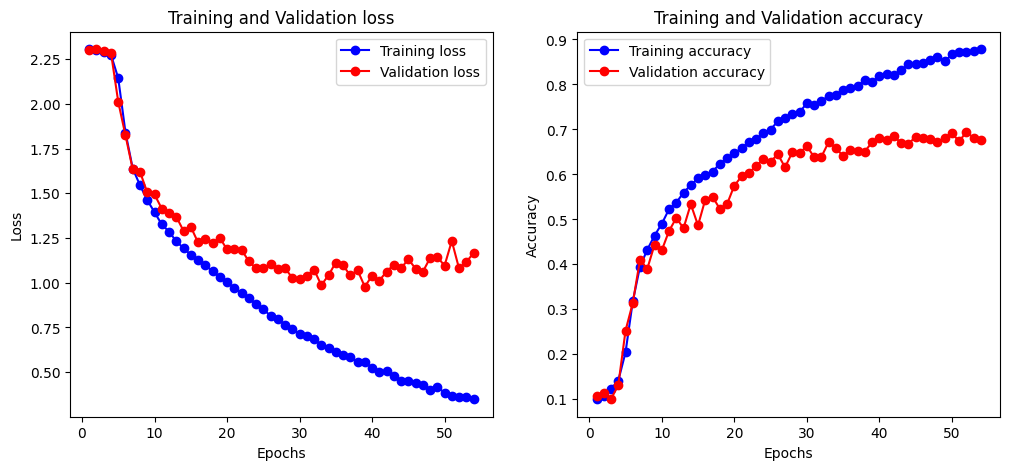

Total Training epoch: 53, Test Accuracy: 0.6640


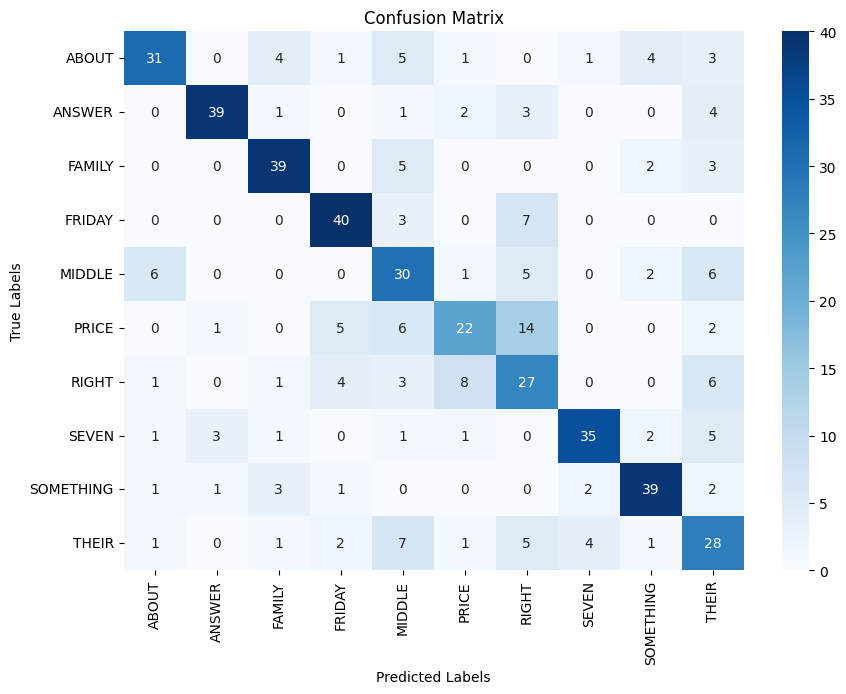

In [25]:
params = {
    'batch_size': 16,
    'hidden_size': 64,
    'learning_rate': 0.001,
    'epoch': 100,
    'num_layers': 2
}
main(params)

In [ ]:
# grid search
batch_size = [16, 32, 64, 128, 512, 1024, 2048, 4096]
hidden_size = [64, 128, 256, 512]
learning_rate = [0.01, 0.001, 0.0001]
epoch = [500]
num_layers = [1, 2, 3]

for bs in batch_size:
  for hs in hidden_size:
    for lr in learning_rate:
      for ep in epoch:
        for nl in num_layers:
          print (f'batch_size: {bs}, hidden_size: {hs}, learning_rate: {lr}, eposh: {ep}, num_layers: {nl};')
          params = {
            'batch_size': bs,
            'hidden_size': hs,
            'learning_rate': lr,
            'epoch': ep,
            'num_layers': nl
          }
          main(params)

batch_size: 16, hidden_size: 64, learning_rate: 0.01, eposh: 500, num_layers: 1;
Total Training epoch: 73, Test Accuracy: 0.1207
batch_size: 16, hidden_size: 64, learning_rate: 0.01, eposh: 500, num_layers: 2;
Total Training epoch: 25, Test Accuracy: 0.1006
batch_size: 16, hidden_size: 64, learning_rate: 0.01, eposh: 500, num_layers: 3;
Total Training epoch: 34, Test Accuracy: 0.0986
batch_size: 16, hidden_size: 64, learning_rate: 0.001, eposh: 500, num_layers: 1;
Total Training epoch: 109, Test Accuracy: 0.6620
batch_size: 16, hidden_size: 64, learning_rate: 0.001, eposh: 500, num_layers: 2;
Total Training epoch: 55, Test Accuracy: 0.7082
batch_size: 16, hidden_size: 64, learning_rate: 0.001, eposh: 500, num_layers: 3;
Total Training epoch: 46, Test Accuracy: 0.6720
batch_size: 16, hidden_size: 64, learning_rate: 0.0001, eposh: 500, num_layers: 1;
Total Training epoch: 227, Test Accuracy: 0.6419
batch_size: 16, hidden_size: 64, learning_rate: 0.0001, eposh: 500, num_layers: 2;
Total T

# Use the model to predict

In [ ]:
lstm_model = LipReadingLSTM(input_size=80, hidden_size=128, num_classes=len(label_classes), num_layers=1)
lstm_model.load_state_dict(torch.load('lip_reading_model.pth', map_location=torch.device('cpu')))

def predict_video(video_path):

    # Prepare data
    start = time.time()
    lip_points, _ = get_lip_points_video(video_path)
    end_frame = time.time()
    print (f'Extract frames Total: {end_frame-start}')
    flat_coordinates = [coord for pair in lip_points for coord in pair]
    reshaped_coordinates = np.array(flat_coordinates).reshape(29, 80)
    feature_tensor = torch.tensor(reshaped_coordinates, dtype=torch.float32)
    feature_tensor = feature_tensor.unsqueeze(0)

    # Model inference
    lstm_model.eval()
    with torch.no_grad():
        output = lstm_model(feature_tensor)
        end_inference = time.time()
        print (f'Inference time: {end_inference-end_frame}')
        predicted_index = output.argmax(dim=1)
        predicted_label = label_classes[predicted_index]
        return predicted_label

label = predict_video('/content/drive/MyDrive/lipread_mp4/SOMETHING/test/SOMETHING_00050.mp4')
print (f'label is {label}')